<a href="https://colab.research.google.com/github/Shai670/Residential_consumption_modeling/blob/main/battery04.09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import clear_output

import matplotlib.pyplot as plt

In [2]:
!git clone https://github.com/Shai670/Residential_consumption_modeling
clear_output()

In [3]:
pv = pd.read_csv('/content/Residential_consumption_modeling/DATA/Kemerovo_2022_solcast_3.csv', index_col='time')
pv.index = pd.date_range(start='2022-01-01 07:00:00', freq='5MIN', periods=len(pv))
pv

,Solar
2022-01-01 07:00:00,-0.1
2022-01-01 07:05:00,-0.1
2022-01-01 07:10:00,-0.1
2022-01-01 07:15:00,-0.1
2022-01-01 07:20:00,-0.1
...,...
2023-01-01 06:35:00,-0.1
2023-01-01 06:40:00,-0.1
2023-01-01 06:45:00,-0.1
2023-01-01 06:50:00,-0.1


In [4]:
load = pd.read_csv("/content/Residential_consumption_modeling/DATA/load.csv", index_col=0)
load.index = pd.to_datetime(load.index)
load

,load
2022-01-01 07:00:00,1.620
2022-01-01 07:05:00,1.546
2022-01-01 07:10:00,1.550
2022-01-01 07:15:00,1.536
2022-01-01 07:20:00,1.534
...,...
2023-01-01 06:35:00,0.208
2023-01-01 06:40:00,0.206
2023-01-01 06:45:00,0.210
2023-01-01 06:50:00,0.208


In [5]:
class battery:


  def __init__(self, Pnom, capacity):
    self.Pnom = Pnom # номинальная мощность батареи
    self.capacity = capacity # ёмкость Вт*ч

    self.SOC_min = .20
    self.SOC_max = .85
    self.SOC = self.SOC_min

    #self.capacity_fact = self.SOC/100 * self.capacity

  def working (self, Pgen, Pload):
     Pbat = 0

     if Pgen > Pload:
       if self.SOC <= self.SOC_max:
         if (Pgen - Pload) >= self.Pnom:
           Pbat = self.Pnom
         elif (Pgen - Pload) < self.Pnom:
           Pbat = Pgen - Pload

     else:
       if self.SOC >= self.SOC_min:
         if Pload - Pgen >= self.Pnom:
           Pbat = -self.Pnom
         elif Pload - Pgen < self.Pnom:
           Pbat = -(Pload-Pgen)

     self.SOC += 5/60 * Pbat / self.capacity

     # self.capacity_fact += 1/60 * Pbat
     # self.SOC = self.capacity_fact / self.capacity * 100

     return Pbat


In [6]:
dataset = pd.merge(load, pv, left_index=True, right_index=True, how='outer').dropna()
dataset.loc[dataset['Solar'] < 0, 'Solar'] = 0
dataset['Solar'] *= 1e-3
dataset

,load,Solar
2022-01-01 07:00:00,1.620,0.0
2022-01-01 07:05:00,1.546,0.0
2022-01-01 07:10:00,1.550,0.0
2022-01-01 07:15:00,1.536,0.0
2022-01-01 07:20:00,1.534,0.0
...,...,...
2023-01-01 06:35:00,0.208,0.0
2023-01-01 06:40:00,0.206,0.0
2023-01-01 06:45:00,0.210,0.0
2023-01-01 06:50:00,0.208,0.0


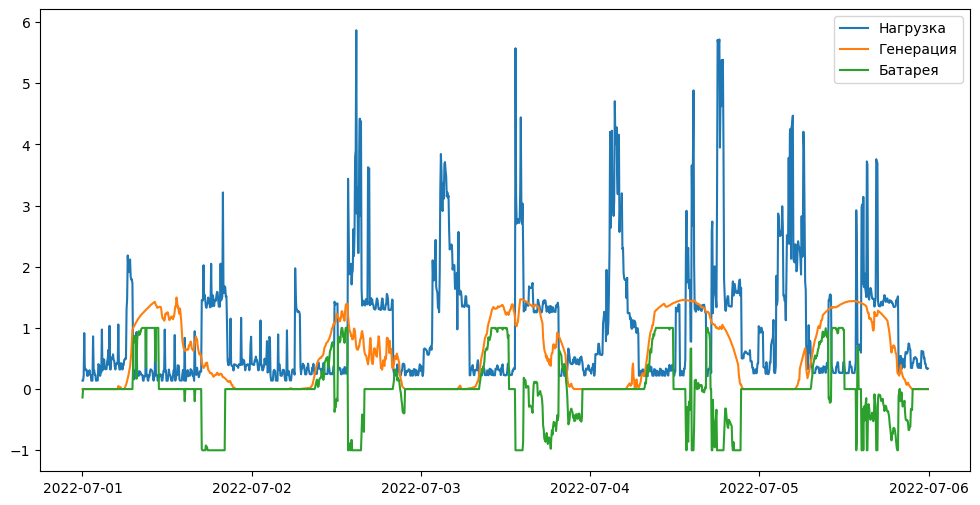

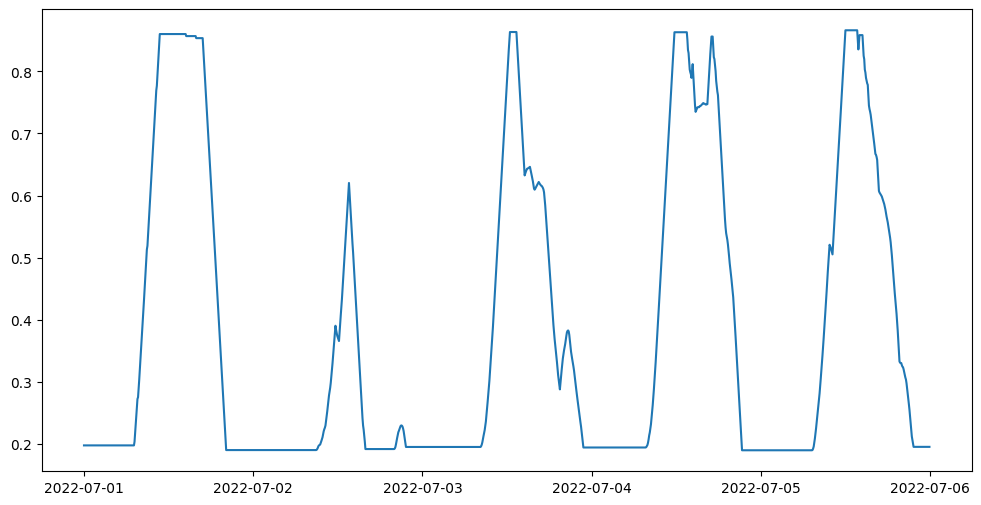

In [7]:
bat = battery(Pnom=1, capacity=5)

start = '2022-07-01'
end = '2022-07-05'

load_data = dataset['load'].loc[start : end]
gen_data  = dataset['Solar'].loc[start : end]

Pbat = []; soc = []; Pgrid = []
for load, gen in zip(load_data, gen_data):
  bat_power = bat.working(Pgen=gen, Pload=load)
  grid_power = load + bat_power - gen

  if grid_power < 0: grid_power = 0

  Pgrid.append(grid_power)
  Pbat.append(bat_power)
  soc.append(bat.SOC)

Pbat = pd.DataFrame({'bat' : Pbat}, index=load_data.index)
Pgrid = pd.DataFrame({'grid' : Pgrid}, index=load_data.index)
soc = pd.DataFrame({'soc' : soc}, index=load_data.index)

plt.figure(figsize=(12,6))
plt.plot(load_data, label='Нагрузка')
plt.plot(gen_data, label='Генерация')
plt.plot(Pbat, label='Батарея')

plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(soc, label='Нагрузка')
plt.show()

In [8]:
def solar_battery_calc(Pnom, capacity):
    bat = battery(Pnom=Pnom, capacity=capacity)

    load_data = dataset['load'].copy()
    gen_data  = dataset['Solar'].copy()

    Pbat = []; soc = []; Pgrid = []
    for load, gen in zip(load_data, gen_data):
        bat_power = bat.working(Pgen=gen, Pload=load)
        grid_power = load + bat_power - gen

        if grid_power < 0: grid_power = 0

        Pgrid.append(grid_power)
        Pbat.append(bat_power)
        soc.append(bat.SOC)

    output = pd.DataFrame(data={"Pbat" : Pbat, "SOC" : soc, "Pgrid" : Pgrid}, index=gen_data.index)

    return output

In [9]:
dataset['load'].mean() * 365 * 24

9375.378833333332

In [10]:
output = solar_battery_calc(Pnom=0, capacity=5)
output.mean() * 365 * 24 / 12

Pbat       0.000000
SOC      146.000000
Pgrid    663.932242
dtype: float64

In [11]:
output = solar_battery_calc(Pnom=3, capacity=10)
output.sum()

Pbat        -0.042501
SOC      30139.717148
Pgrid    85958.997645
dtype: float64

In [12]:
output = solar_battery_calc(Pnom=5, capacity=10)
output.sum()

Pbat        -0.043446
SOC      30013.490587
Pgrid    85956.008552
dtype: float64

In [13]:
output = solar_battery_calc(Pnom=7.2, capacity=20)
output.sum()

Pbat        -0.045632
SOC      27660.248870
Pgrid    85385.576667
dtype: float64

,p,c,W
0,0.10,0.10,95148.0
1,0.10,0.15,95037.0
2,0.10,0.20,94938.0
3,0.10,0.25,94845.0
4,0.10,0.30,94758.0
...,...,...,...
1439,1.95,1.75,91617.0
1440,1.95,1.80,91542.0
1441,1.95,1.85,91482.0
1442,1.95,1.90,91408.0


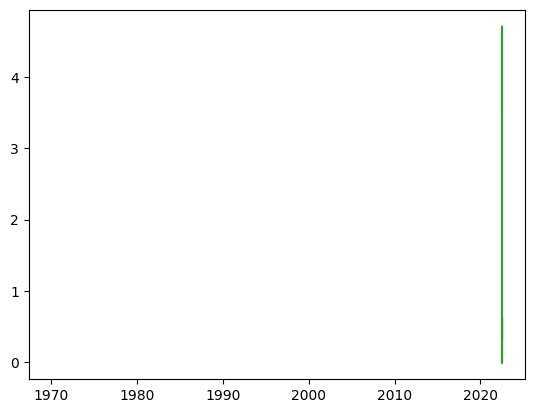

In [21]:
result = pd.DataFrame()

i = 0
for p in np.arange(0.1, 2, .05):
    for c in np.arange(0.1, 2, .05):
        output = solar_battery_calc(Pnom=p, capacity=c)

        result.loc[i, "p"] = p
        result.loc[i, "c"] = c
        result.loc[i, "W"] = output["Pgrid"].sum().round()

        i += 1
plt.plot(p, label='Мощность')
plt.plot(c, label='Ёмкость солнечной панели')
plt.plot(Pgrid, label='Электропотребелние')

result



In [23]:
result_pivot = pd.pivot_table(
    result, index="p", columns="c", values="W"
)
result_pivot

c,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,...,1.50,1.55,1.60,1.65,1.70,1.75,1.80,1.85,1.90,1.95
p,,,,,,,,,,,,,,,,,,,,,
0.10,95148.0,95037.0,94938.0,94845.0,94758.0,94676.0,94597.0,94522.0,94450.0,94383.0,...,93826.0,93819.0,93813.0,93809.0,93806.0,93803.0,93801.0,93799.0,93797.0,93796.0
0.15,95084.0,94955.0,94846.0,94744.0,94648.0,94554.0,94465.0,94380.0,94297.0,94218.0,...,93246.0,93222.0,93200.0,93178.0,93159.0,93141.0,93123.0,93108.0,93092.0,93078.0
0.20,95037.0,94901.0,94781.0,94670.0,94568.0,94469.0,94375.0,94283.0,94194.0,94108.0,...,92872.0,92830.0,92789.0,92753.0,92718.0,92687.0,92653.0,92624.0,92598.0,92572.0
0.25,95002.0,94860.0,94730.0,94615.0,94505.0,94405.0,94306.0,94206.0,94117.0,94024.0,...,92666.0,92609.0,92557.0,92502.0,92449.0,92399.0,92352.0,92305.0,92260.0,92218.0
0.30,94971.0,94826.0,94691.0,94572.0,94458.0,94351.0,94249.0,94150.0,94054.0,93968.0,...,92531.0,92470.0,92408.0,92350.0,92291.0,92229.0,92176.0,92117.0,92065.0,92009.0
0.35,94946.0,94800.0,94664.0,94544.0,94425.0,94316.0,94207.0,94105.0,94011.0,93914.0,...,92430.0,92364.0,92303.0,92240.0,92175.0,92116.0,92051.0,91995.0,91932.0,91874.0
0.40,94922.0,94771.0,94639.0,94514.0,94391.0,94284.0,94174.0,94071.0,93970.0,93874.0,...,92356.0,92290.0,92220.0,92155.0,92086.0,92025.0,91959.0,91898.0,91837.0,91777.0
0.45,94901.0,94759.0,94623.0,94496.0,94370.0,94254.0,94141.0,94040.0,93941.0,93844.0,...,92299.0,92231.0,92159.0,92088.0,92021.0,91956.0,91891.0,91826.0,91765.0,91699.0
0.50,94893.0,94742.0,94597.0,94476.0,94350.0,94232.0,94118.0,94010.0,93915.0,93812.0,...,92250.0,92183.0,92110.0,92045.0,91972.0,91903.0,91837.0,91772.0,91704.0,91639.0


<Axes: xlabel='c', ylabel='p'>

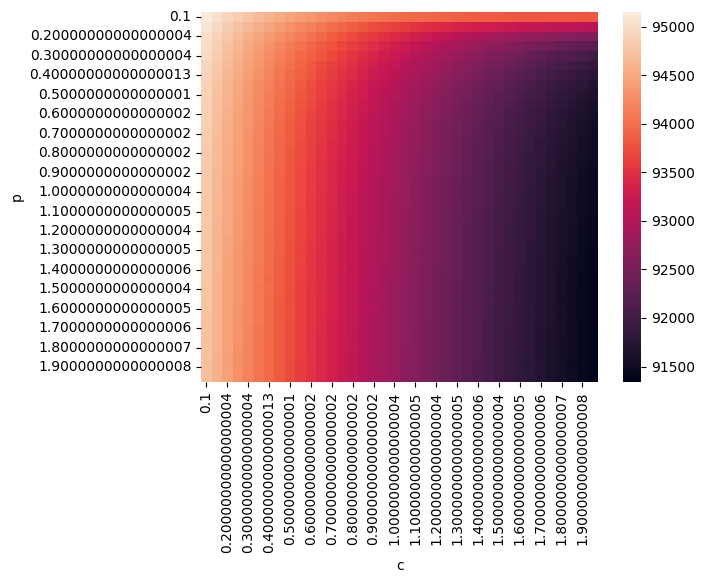

In [24]:
import seaborn as sns

sns.heatmap(result_pivot)